# Clean code of the abstract
Just the exact same procedure, data and results

In [1]:
%matplotlib inline

In [2]:
import os
import re
import sys
sys.path.append('/home/surchs/git/HPS')
from hps.predic import high_confidence
from hps.visu import hps_visu
sys.path.append('/home/surchs/git/HPS/examples/')
import visu_demo

import numpy as np
import pandas as pd
import nibabel as nib
import sklearn as skl
import scipy.io as sio
import seaborn as sbn
from scipy import stats as spt
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Paths
root_p = '/home/surchs/sim_big/PROJECT/abide_hps/'
# Pheno
sample_p = os.path.join(root_p, 'pheno', 'psm_abide1.csv')
# Data
mask_p = os.path.join(root_p, 'mask', 'MIST_mask.nii.gz')
label_p = os.path.join(root_p, 'mask', 'roi_label_scale_20_overlap.csv')
weight_fc_p = os.path.join(root_p, 'weights', 'weights_fc_psm.npy')
weight_ct_p = os.path.join(root_p, 'weights', 'weights_ct_psm.npy')

In [5]:
# Load data
sample = pd.read_csv(sample_p)
sample['DX_CODE'] = sample['DX_GROUP'].replace({'Autism':1, 'Control':0})
label = pd.read_csv(label_p, delimiter=';')

w_fc = np.load(weight_fc_p)
w_ct = np.load(weight_ct_p)

In [6]:
w_fc.shape

(370, 5, 20)

In [7]:
n_sub = sample.shape[0]
n_subtypes = w_fc.shape[1]
# Reshape FC to add to the table
fc_weights = np.reshape(w_fc, (n_sub, n_subtypes*20))
fc_cols = ['fc_n{}_s{}'.format(nid+1, sid+1) for sid in range(n_subtypes) for nid in range(20)]
# Same for CT
ct_weights = w_ct
ct_cols = ['ct_s{}'.format(sid+1) for sid in range(n_subtypes)]
# Combine both
weights = np.concatenate((ct_weights, fc_weights),1)
cols = ct_cols + fc_cols
# Into a pandas DF
w_data = pd.DataFrame(data=weights, columns=cols)
# Combine both for the full dataset
dataset = sample.join(w_data)

In [8]:
# Select the features
scaler = skl.preprocessing.StandardScaler()
# Add BV to the subtype weights
col_features = ['BV', 'AGE_AT_SCAN', 'FD_scrubbed', ] + cols

# Build features
x_ = dataset.loc[:, col_features]
# Take the numeric diagnosis code, 0 is control, 1 is autism
y = dataset.loc[:, ['DX_CODE']].values.squeeze()
# Normalize
X = scaler.fit_transform(x_)
#X = scaler.transform(x_)

# Run the CV model

In [9]:
ohe = skl.preprocessing.OneHotEncoder(sparse=False)
ohe.fit(y.reshape(-1, 1))
labels = ohe.transform(y.reshape(-1, 1))

In [10]:
scores_s1=[]
scores_s2 = []
y_target = []

skf = StratifiedKFold(n_splits=10)
it = 1
for train_index, val_index in skf.split(X,y):
    X_training, X_val = X[train_index], X[val_index]
    y_training, y_val = y[train_index], y[val_index]
        
    hps = high_confidence.TwoStagesPrediction(verbose=False,
                                          n_iter=1000,
                                          shuffle_test_split=0.5,
                                            gamma=0.98,
                                          min_gamma=0.95,
                                          thresh_ratio=0.1)
    
    hps.fit(X_training, y_training)
    
    scores, dic_results = hps.predict(X_val)
    
    # Test in validation sample
    acc = skl.metrics.accuracy_score(y_val, (dic_results['s1_df'][:,0]>0).astype(float))
    tmp_mask = (dic_results['s2_hat'][:,1]>0) & (dic_results['s1_df'][:,0]>0)
    acc_s2 = skl.metrics.accuracy_score(y_val, (dic_results['s2_df'][:,1]>0).astype(float))
    
    scores_s1.append(dic_results['s1_hat'])
    scores_s2.append(dic_results['s2_hat'])
    
    print('CV fold {} classifying...'.format(it))
    it += 1
    
    y_target.append(y_val)

Stage 1
Stage 2
CV fold 1 classifying...
Stage 1
Stage 2
CV fold 2 classifying...
Stage 1
Stage 2
CV fold 3 classifying...
Stage 1
Stage 2
CV fold 4 classifying...
Stage 1
Stage 2
CV fold 5 classifying...
Stage 1
Stage 2
CV fold 6 classifying...
Stage 1
Stage 2
CV fold 7 classifying...
Stage 1
Stage 2
CV fold 8 classifying...
Stage 1
Stage 2
CV fold 9 classifying...
Stage 1
Stage 2
CV fold 10 classifying...


In [11]:
scores_s1 = np.vstack(scores_s1)
scores_s2 = np.vstack(scores_s2)
y_target = np.hstack(y_target)

########################
print('##########################')
# S1
y_mb = ohe.transform(y_target[:,np.newaxis])
pred_y_ = scores_s1

print('Stage 1 (BASE)')
hps_visu.print_scores(hps_visu.scores(y_mb, pred_y_))


# S2
y_mb = ohe.transform(y_target[:,np.newaxis])
pred_y_ = scores_s2

print('Stage 2 (HPS)')
hps_visu.print_scores(hps_visu.scores(y_mb, pred_y_)) 
print('##########################')

##########################
Stage 1 (BASE)
Class 0 Precision: 58.64 Specificity: 56.59 Recall: 59.57 N: 191
Class 1 Precision: 57.54 Specificity: 59.57 Recall: 56.59 N: 179
Total Precision: 58.09 Specificity: 58.08 Recall: 58.08 N: 185
Stage 2 (HPS)
Class 0 Precision: 78.05 Specificity: 95.05 Recall: 17.02 N: 41
Class 1 Precision: 85.00 Specificity: 96.81 Recall: 18.68 N: 40
Total Precision: 81.52 Specificity: 95.93 Recall: 17.85 N: 40
##########################


That looks pretty good, let's run this on the entire training set and see if it generalizes to the validation set

## NEW June 18
Class 0 here is the Control class. Class 1 is the Autism class (see above onehot encoder)

In [81]:
dataset['DX_GROUP'].value_counts()

Control    188
Autism     182
Name: DX_GROUP, dtype: int64

In [91]:
# How many individuals were labeled easy controls and patients
np.sum(scores_s2, 0)

array([41, 40])

In [82]:
tn, fp, fn, tp = skl.metrics.confusion_matrix(y_mb[:, 1], scores_s2[: , 1]).ravel().astype(float)

In [83]:
tp + fn

182.0

In [84]:
tn + fp

188.0

In [86]:
# Precision, how many of those labeled as ASD are actually ASD
tp / (tp+fp)

0.85

In [87]:
# Sensitivity/Recall, how many of those actually ASD are labeled ASD
tp / (tp+fn)

0.18681318681318682

In [93]:
# Specificity, how many labeled controls are actually controls
tn / (tn+fp)

0.9680851063829787

In [72]:
fp

6.0

In [73]:
tp

34.0

In [74]:
fn

148.0

In [75]:
tp + fn

182.0

In [76]:
dataset.shape

(370, 202)

Control    188
Autism     182
Name: DX_GROUP, dtype: int64

In [42]:
hps_visu.scores(y_mb, pred_y_)

[[0.7804878048780488, 0.9505494505494505, 0.1702127659574468, 41],
 [0.85, 0.9680851063829787, 0.18681318681318682, 40]]

# Run the one-pass model

In [1]:
res_hitproba = []

hps_train = high_confidence.TwoStagesPrediction(verbose=False,
                                          n_iter=1000,
                                          shuffle_test_split=0.5,
                                          gamma=0.98,
                                          min_gamma=0.95,
                                          thresh_ratio=0.1)
hps_train.fit(X,y)
res_hitproba = hps_train.training_hit_probability

plt.figure()
plt.title('Class 0 hit probability distribution')
plt.hist(hps_train.training_hit_probability[y==0],10);
plt.figure()
plt.title('Class 1 hit probability distribution')
plt.hist(hps_train.training_hit_probability[y==1],10);

NameError: name 'high_confidence' is not defined

In [13]:
scores, dic_results = hps_train.predict(X)

# Test in validation sample
acc = skl.metrics.accuracy_score(y, (dic_results['s1_df'][:,0]>0).astype(float))
tmp_mask = (dic_results['s2_hat'][:,1]>0) & (dic_results['s1_df'][:,0]>0)
acc_s2 = skl.metrics.accuracy_score(y, (dic_results['s2_df'][:,1]>0).astype(float))

In [26]:
# Get the performance of the full model
print('Stage 1 (BASE)')
hps_visu.print_scores(hps_visu.scores(ohe.transform(y[:,np.newaxis]), dic_results['s1_hat']))
print('Stage 2 (HPS)')
hps_visu.print_scores(hps_visu.scores(ohe.transform(y[:,np.newaxis]), dic_results['s2_hat']))

Stage 1 (BASE)
Class 0 Precision: 70.68 Specificity: 69.23 Recall: 71.81 N: 191
Class 1 Precision: 70.39 Specificity: 71.81 Recall: 69.23 N: 179
Total Precision: 70.54 Specificity: 70.52 Recall: 70.52 N: 185
Stage 2 (HPS)
Class 0 Precision: 88.46 Specificity: 96.70 Recall: 24.47 N: 52
Class 1 Precision: 100.00 Specificity: 100.00 Recall: 19.78 N: 36
Total Precision: 94.23 Specificity: 98.35 Recall: 22.12 N: 44


## Get a hold of the feature weights in the model

In [27]:
# Get the feature weights for class 1 / second stage (not sure which)
feature_weights = hps_train.confidencemodel.clfs[1].coef_
# Get the non-zero weights
non_zero = np.where(feature_weights!=0)[1]

In [30]:
col_nonzero = [col_features[ind] for ind in non_zero]

feature_type = list()
for col in col_nonzero:
    if 'ct' in col:
        feature_type.append('Anatomical')
    elif 'fc' in col:
        feature_type.append('Functional')
    else:
        feature_type.append('Phenotype')
data = {'weights':feature_weights[0, non_zero],
            'feature':col_nonzero,
            'feature_type':feature_type}
weights = pd.DataFrame(data=data)

In [31]:
fc_sorted = ['fc_n{}_s{}'.format(nid+1, sid+1) for nid in range(20) for sid in range(n_subtypes) 
           if 'fc_n{}_s{}'.format(nid+1, sid+1) in col_nonzero]
col_sorted = ['BV', 'AGE_AT_SCAN'] + ['ct_s1', 'ct_s5'] + fc_sorted
sort_ind = [col_features.index(feat) for feat in col_sorted]

In [34]:
feature_type = list()
feature_names = list()
for col in col_sorted:
    if 'ct' in col:
        feature_type.append('Anatomical')
    elif 'fc' in col:
        feature_type.append('Functional')
    else:
        feature_type.append('Phenotype')
    # Get the real name, yo
    net_s = re.search(r'(?<=fc_n)[0-9]+', col)
    sub_s = re.search(r'(?<=_s)[0-9]', col)
    if net_s and sub_s:
        net = int(net_s.group())
        net_name = label[label['roi']==net]['label'].values[0]
        sub = int(sub_s.group())
        f_name = 'FC_{}_subtype_{}'.format(net_name, sub)
        feature_names.append(f_name)
    elif sub_s and 'ct' in col:
        sub = int(sub_s.group())
        f_name = 'CT_subtype_{}'.format(sub)
        feature_names.append(f_name)
    else:
        feature_names.append(col)
        
data_sorted = {'weights':feature_weights[0, sort_ind],
            'feature':feature_names,
            'feature_type':feature_type}
weights_sorted = pd.DataFrame(data=data_sorted)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]), <a list of 40 Text xticklabel objects>)

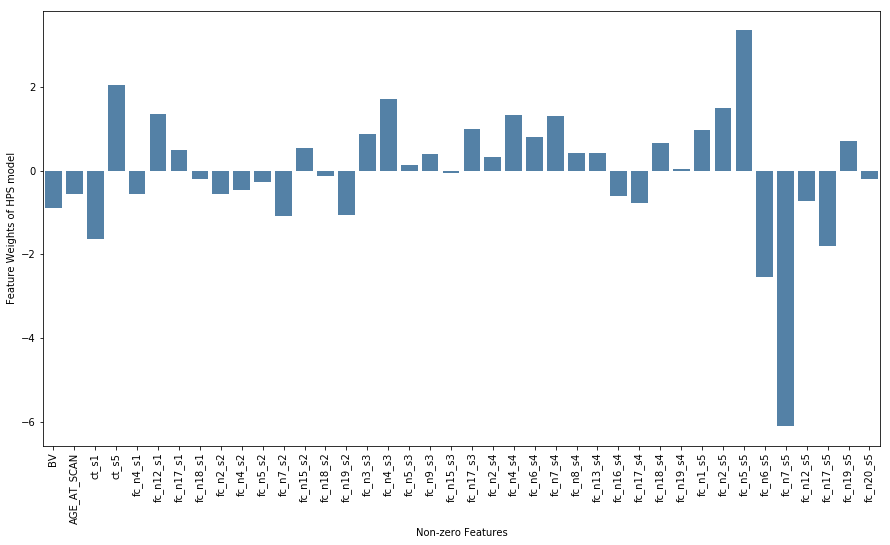

In [35]:
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(111)
#g = sbn.barplot(x='feature', y='weights', data=weights, hue='feature_type', ax=ax)
g = sbn.barplot(x='feature', y='weights', data=weights, ax=ax, ci=None, color='steelblue')
g.set(xlabel='Non-zero Features', ylabel='Feature Weights of HPS model')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]), <a list of 39 Text xticklabel objects>)

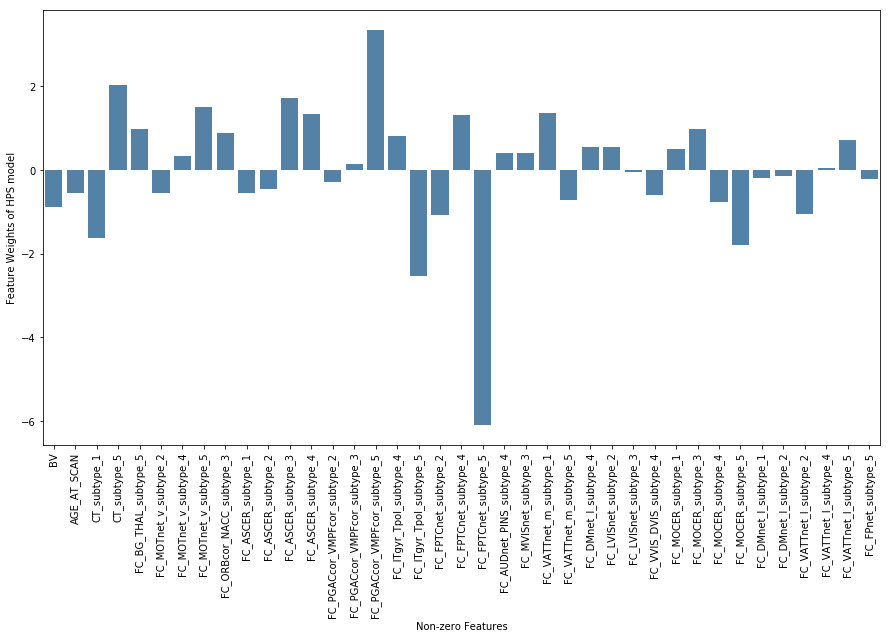

In [37]:
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(111)
#g = sbn.barplot(x='feature', y='weights', data=weights, hue='feature_type', ax=ax)
g = sbn.barplot(x='feature', y='weights', data=weights_sorted, ax=ax, ci=None, color='steelblue')
g.set(xlabel='Non-zero Features', ylabel='Feature Weights of HPS model')
plt.xticks(rotation=90)


In [38]:
# Identify people classified as easy cases
HPS_ind = ind_hps==1

NameError: name 'ind_hps' is not defined

In [43]:
# Give me three classes here
asd_hps = [True if HPS_ind[rid]==1 and row['DX_GROUP']=='Autism' else False for rid, row in sample.iterrows()]
asd_ns = [True if HPS_ind[rid]==0 and row['DX_GROUP']=='Autism' else False for rid, row in sample.iterrows()]
tdc = [True if row['DX_GROUP']=='Control' else False for rid, row in sample.iterrows()]
group = list()
for rid, row in sample.iterrows():
    if asd_hps[rid]:
        group.append('ASD_HPS')
    elif asd_ns[rid]:
        group.append('ASD_NS')
    else:
        group.append('TDC')
results = sample.copy()
results['Group'] = group
# Remove missing values
results.replace({col:{-9999:None} for col in results.columns}, inplace=True)

## Age

In [46]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

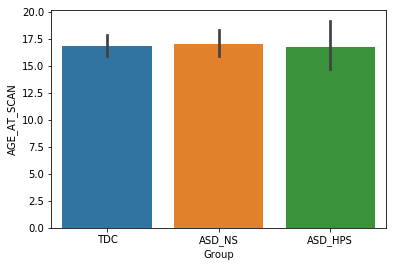

In [46]:
sbn.barplot(x='Group', y='AGE_AT_SCAN', data=results)

In [62]:
lm = ols('AGE_AT_SCAN ~ Group',
               data=results).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
Group,2.912911,2.0,0.028069,0.972324
Residual,19043.159714,367.0,NaN,NaN


No age differences. Nice, nice

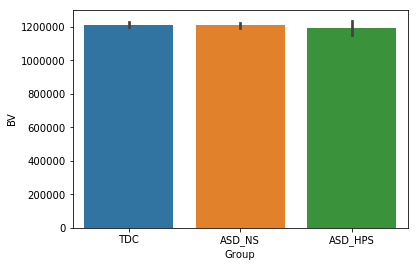

In [44]:
sbn.barplot(x='Group', y='BV', data=results)

In [47]:
lm = ols('BV ~ Group',
               data=results).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
Group,1.078890e+10,2.0,0.483176,0.617213
Residual,4.097392e+12,367.0,NaN,NaN


In [48]:
pwt = pairwise_tukeyhsd(results['BV'], results['Group'], alpha=0.05)
print(pwt)

   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
 group1 group2  meandiff     lower      upper    reject
-------------------------------------------------------
ASD_HPS ASD_NS 14525.4546 -31746.5724 60797.4817 False 
ASD_HPS  TDC   18778.1541 -26459.9445 64016.2528 False 
 ASD_NS  TDC   4252.6995  -23177.4636 31682.8626 False 
-------------------------------------------------------


## Motion

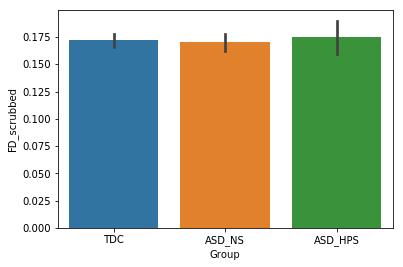

In [25]:
sbn.barplot(x='Group', y='FD_scrubbed', data=results)

In [63]:
lm = ols('FD_scrubbed ~ Group',
               data=results).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
Group,0.000604,2.0,0.152349,0.858743
Residual,0.727181,367.0,NaN,NaN


In [70]:
pwt = pairwise_tukeyhsd(results['FD_scrubbed'], results['Group'], alpha=0.05)
print(pwt)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1 group2 meandiff  lower  upper  reject
---------------------------------------------
ASD_HPS ASD_NS -0.0044  -0.0239 0.0151 False 
ASD_HPS  TDC   -0.0029  -0.0219 0.0162 False 
 ASD_NS  TDC    0.0015   -0.01  0.0131 False 
---------------------------------------------


Also no apparent motion differences, maybe a slight trend for the ASD HPS guys

## FIQ
Now for the more relevant stuff

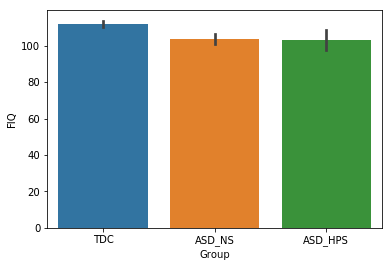

In [26]:
sbn.barplot(x='Group', y='FIQ', data=results)

In [64]:
lm = ols('FIQ ~ Group',
               data=results).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
Group,6264.911021,2.0,14.292807,0.000001
Residual,79994.523761,365.0,NaN,NaN


In [76]:
temp = results.dropna(subset=['FIQ'])
pwt = pairwise_tukeyhsd(temp['FIQ'], temp['Group'], alpha=0.05)
print(pwt)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1 group2 meandiff  lower   upper  reject
----------------------------------------------
ASD_HPS ASD_NS  0.5539  -5.9337  7.0416 False 
ASD_HPS  TDC    8.6911    2.35  15.0322  True 
 ASD_NS  TDC    8.1372   4.282  11.9924  True 
----------------------------------------------


No difference between the ASD groups

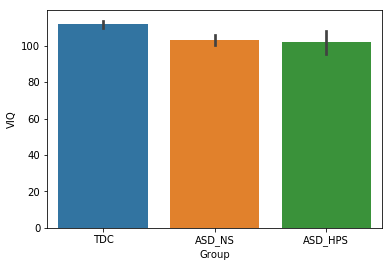

In [27]:
sbn.barplot(x='Group', y='VIQ', data=results)

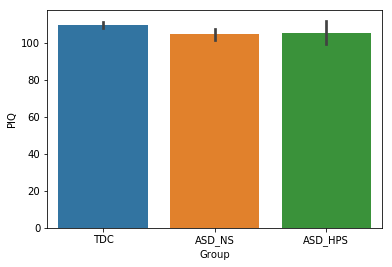

In [28]:
sbn.barplot(x='Group', y='PIQ', data=results)

## SRS

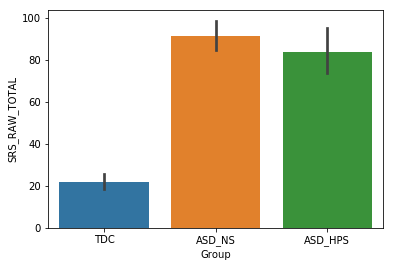

In [29]:
sbn.barplot(x='Group', y='SRS_RAW_TOTAL', data=results)

## ADOS Severity

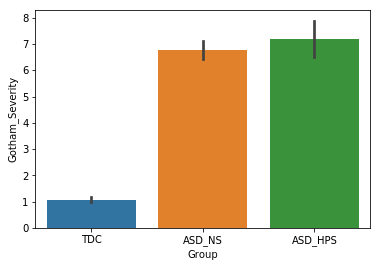

In [72]:
sbn.barplot(x='Group', y='Gotham_Severity', data=results)

In [73]:
lm = ols('Gotham_Severity ~ Group',
               data=results).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
Group,800.299104,2.0,113.595185,6.558953e-33
Residual,651.679620,185.0,NaN,NaN


In [75]:
temp = results.dropna(subset=['Gotham_Severity'])
pwt = pairwise_tukeyhsd(temp['Gotham_Severity'], temp['Group'], alpha=0.05)
print(pwt)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1 group2 meandiff  lower   upper  reject
----------------------------------------------
ASD_HPS ASD_NS  -0.418  -1.2846  0.4485 False 
ASD_HPS  TDC   -6.1104  -7.2499 -4.9709  True 
 ASD_NS  TDC   -5.6924  -6.6182 -4.7665  True 
----------------------------------------------


In [ ]:
temp = results.dropna(subset=['Gotham_Severity'])

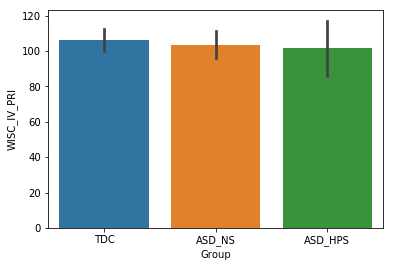

In [31]:
sbn.barplot(x='Group', y='WISC_IV_PRI', data=results)

If anything, we have found less severe cases here, it seems

## Handedness

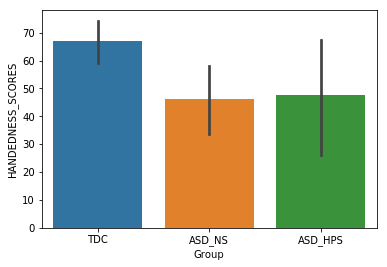

In [32]:
sbn.barplot(x='Group', y='HANDEDNESS_SCORES', data=results)

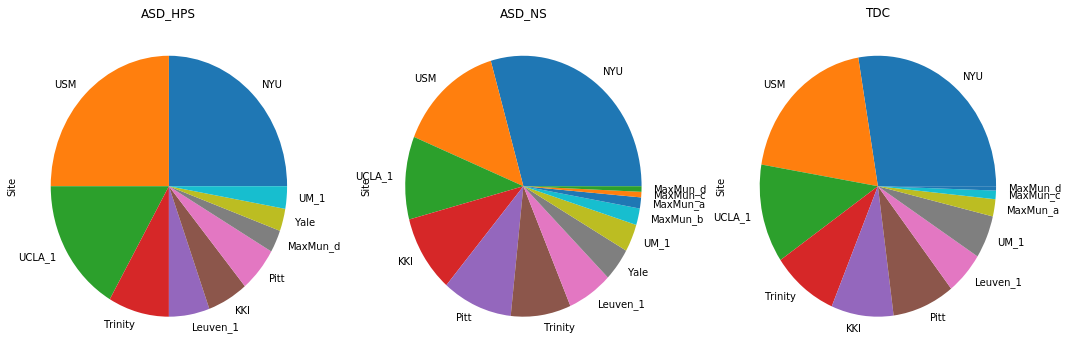

In [33]:
f = plt.figure(figsize=(18, 6))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
for rid, g in enumerate(results.groupby('Group')):
    ax = f.add_subplot(1,3,rid+1)
    g[1]['Site'].value_counts().plot.pie(ax=ax)
    ax.set_title(g[0])

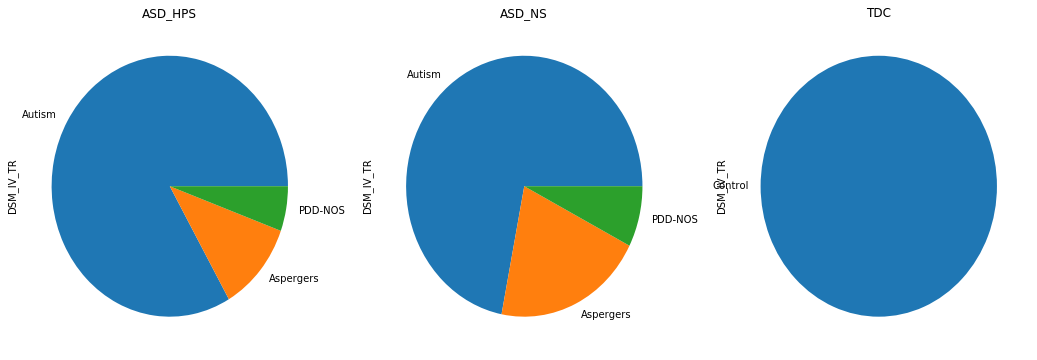

In [34]:
f = plt.figure(figsize=(18, 6))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
for rid, g in enumerate(results.groupby('Group')):
    ax = f.add_subplot(1,3,rid+1)
    g[1]['DSM_IV_TR'].value_counts().plot.pie(ax=ax)
    ax.set_title(g[0])

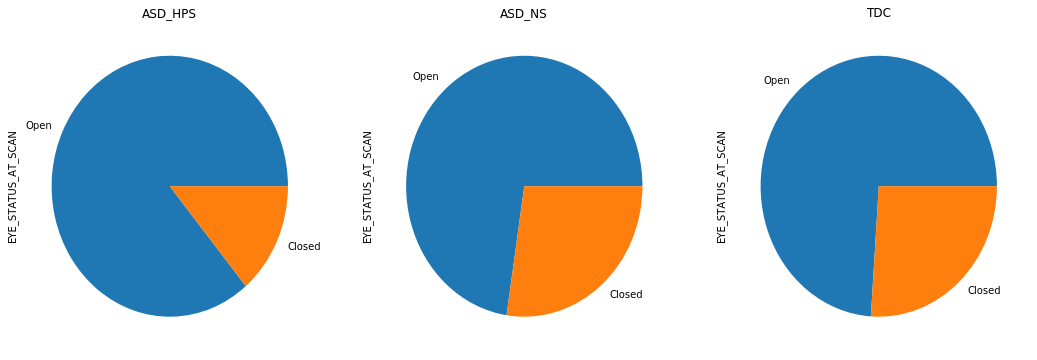

In [35]:
f = plt.figure(figsize=(18, 6))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
for rid, g in enumerate(results.groupby('Group')):
    ax = f.add_subplot(1,3,rid+1)
    g[1]['EYE_STATUS_AT_SCAN'].value_counts().plot.pie(ax=ax)
    ax.set_title(g[0])

Ok, none of that works

In [36]:
results.columns

Index(['Civet_ID', 'Manual_Rating', 'Site', 'Subject', 'Session', 'Run',
       'SUB_ID', 'Ratings', 'id_subject', 'status', 'anat', 'comment_anat',
       'func', 'comment_func', 'frames_scrubbed', 'frames_OK', 'FD',
       'FD_scrubbed', 'SITE_ID', 'DX_GROUP', 'DSM_IV_TR', 'AGE_AT_SCAN', 'SEX',
       'HANDEDNESS_CATEGORY', 'HANDEDNESS_SCORES', 'FIQ', 'VIQ', 'PIQ',
       'FIQ_TEST_TYPE', 'VIQ_TEST_TYPE', 'PIQ_TEST_TYPE',
       'ADI_R_SOCIAL_TOTAL_A', 'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C',
       'ADI_R_ONSET_TOTAL_D', 'ADI_R_RSRCH_RELIABLE', 'ADOS_MODULE',
       'ADOS_TOTAL', 'ADOS_COMM', 'ADOS_SOCIAL', 'ADOS_STEREO_BEHAV',
       'ADOS_RSRCH_RELIABLE', 'ADOS_GOTHAM_SOCAFFECT', 'ADOS_GOTHAM_RRB',
       'ADOS_GOTHAM_TOTAL', 'ADOS_GOTHAM_SEVERITY', 'SRS_VERSION',
       'SRS_RAW_TOTAL', 'SRS_AWARENESS', 'SRS_COGNITION', 'SRS_COMMUNICATION',
       'SRS_MOTIVATION', 'SRS_MANNERISMS', 'SCQ_TOTAL', 'AQ_TOTAL',
       'COMORBIDITY', 'CURRENT_MED_STATUS', 'MEDICATION_NAME',
       

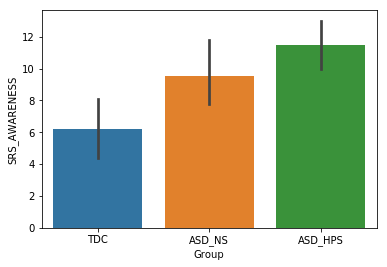

In [37]:
sbn.barplot(x='Group', y='SRS_AWARENESS', data=results)

In [77]:
temp = results.dropna(subset=['SRS_AWARENESS'])
pwt = pairwise_tukeyhsd(temp['SRS_AWARENESS'], temp['Group'], alpha=0.05)
print(pwt)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1 group2 meandiff  lower   upper  reject
----------------------------------------------
ASD_HPS ASD_NS -1.9444  -8.0793  4.1905 False 
ASD_HPS  TDC     -5.3   -11.3789 0.7789 False 
 ASD_NS  TDC   -3.3556  -6.9614  0.2503 False 
----------------------------------------------


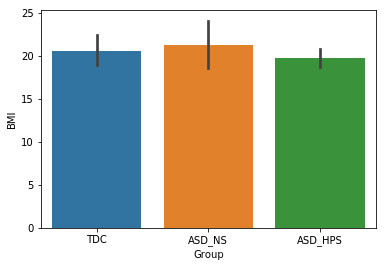

In [38]:
sbn.barplot(x='Group', y='BMI', data=results)

# Validation

In [15]:
# Add BV to the subtype weights
col_features = ['BV', 'AGE_AT_SCAN', 'FD_scrubbed', ] + cols

# Build features
x_val = data_val.loc[:, col_features]
# Take the numeric diagnosis code
y_val = data_val.loc[:, ['DX_CODE']].values.squeeze()
# Normalize
X_val = scaler.transform(x_val)

In [18]:
skl.metrics.accuracy_score(y_val, hps_train.basemodel.decision_function(X_val)>0)

0.5683297180043384

In [19]:
print(skl.metrics.classification_report(y_val, hps_train.basemodel.decision_function(X_val)>0))

             precision    recall  f1-score   support

          0       0.62      0.56      0.59       255
          1       0.52      0.57      0.54       206

avg / total       0.57      0.57      0.57       461



In [20]:
print(skl.metrics.classification_report(y_val, hps_train.confidencemodel.decision_function(X_val)[:, 1]>0))

             precision    recall  f1-score   support

          0       0.57      0.95      0.71       255
          1       0.61      0.10      0.17       206

avg / total       0.58      0.57      0.47       461



Stage 1
Stage 2


(array([ 16.,  13.,   9.,   6.,  11.,  19.,  28.,  25.,  29.,  50.]),
 array([ 0.002 ,  0.1018,  0.2016,  0.3014,  0.4012,  0.501 ,  0.6008,
         0.7006,  0.8004,  0.9002,  1.    ]),
 <a list of 10 Patch objects>)

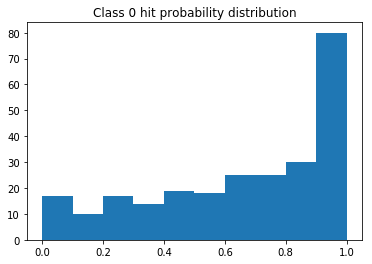

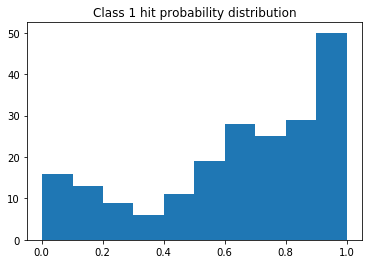

In [57]:
res_hitproba = []

hps = high_confidence.TwoStagesPrediction(verbose=False,
                                          n_iter=1000,
                                          shuffle_test_split=0.5,
                                          gamma=0.98,
                                          min_gamma=0.95,
                                          thresh_ratio=0.1)
hps.fit(X_val,y_val)
res_hitproba = hps.training_hit_probability

plt.figure()
plt.title('Class 0 hit probability distribution')
plt.hist(hps.training_hit_probability[y_val==0],10)
plt.figure()
plt.title('Class 1 hit probability distribution')
plt.hist(hps.training_hit_probability[y_val==1],10)

In [24]:
skl.metrics.accuracy_score(y_val, hps.basemodel.decision_function(X_val)>0)

0.81561822125813443

In [71]:
skl.metrics.accuracy_score(y_val, hps.confidencemodel.decision_function(X_val)[:, 1]>0)

0.62472885032537961

In [25]:
print(skl.metrics.classification_report(y_val, hps.basemodel.decision_function(X_val)>0))

             precision    recall  f1-score   support

          0       0.86      0.80      0.83       255
          1       0.77      0.83      0.80       206

avg / total       0.82      0.82      0.82       461



In [26]:
print(skl.metrics.classification_report(y_val, hps.confidencemodel.decision_function(X_val)[:, 1]>0))

             precision    recall  f1-score   support

          0       0.60      1.00      0.75       255
          1       1.00      0.16      0.28       206

avg / total       0.78      0.62      0.54       461



In [27]:
# Get the feature weights for class 1 / second stage (not sure which)
feature_weights = hps.confidencemodel.clfs[1].coef_
# Get the non-zero weights
non_zero = np.where(feature_weights!=0)[1]

In [28]:
col_nonzero = [col_features[ind] for ind in non_zero]
feature_type = list()
for col in col_nonzero:
    if 'ct' in col:
        feature_type.append('Anatomical')
    elif 'fc' in col:
        feature_type.append('Functional')
    else:
        feature_type.append('Phenotype')
data = {'weights':feature_weights[0, non_zero],
            'feature':col_nonzero,
            'feature_type':feature_type}
weights = pd.DataFrame(data=data)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 <a list of 60 Text xticklabel objects>)

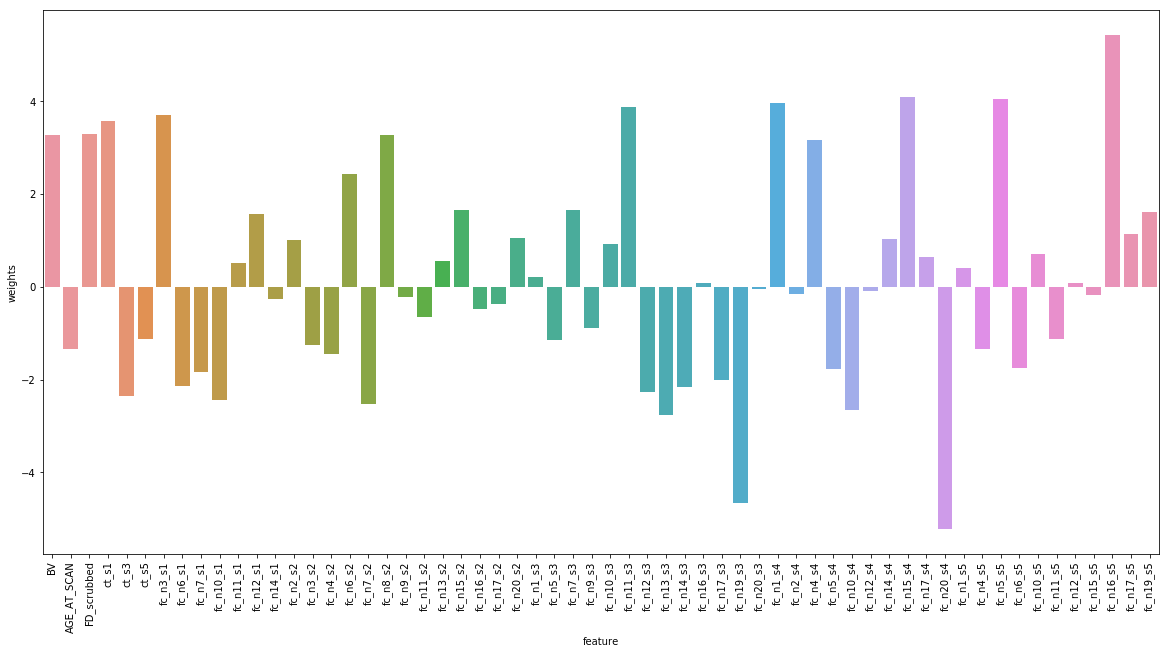

In [29]:
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(111)
#g = sbn.barplot(x='feature', y='weights', data=weights, hue='feature_type', ax=ax)
g = sbn.barplot(x='feature', y='weights', data=weights, ax=ax)
plt.xticks(rotation=90)